# OFTI Introduction #

by Isabel Angelo and Sarah Blunt (2018)

Adapted and modified by Junellie Gonzalez Quiles for the Flatiron Tutorial Event (2019)

OFTI (Orbits For The Impatient) is an orbit-generating algorithm designed specifically to handle data covering short fractions of long-period exoplanets ([Blunt et al. 2017](https://ui.adsabs.harvard.edu/#abs/2017AJ....153..229B/abstract)). Here we go through steps of using OFTI within `orbitize`!

In [1]:
import orbitize
import astroquery.simbad
import astropy.units as u
import numpy as np
import os

## Basic Orbit Generating##

Orbits are generated in OFTI through a `Driver` class within orbitize. We import this class:

In [2]:
import orbitize.driver

We obtain parallax of the star from SIMBAD

In [3]:
star_name = "47 UMa"

customSimbad = astroquery.simbad.Simbad()
customSimbad.add_votable_fields('plx','plx_error')
simbad_table = customSimbad.query_object(star_name)

In [4]:
plx = simbad_table['PLX_VALUE'][0]
plx_err = simbad_table['PLX_ERROR'][0]

In [5]:
print(plx, plx_err)

72.4528 0.1507


we can initialize a `Driver` object specific to our data:

In [6]:
%ls ../../Data

HLC/          SS/           planet_b.csv  rv.dat


In [7]:
planet = 'b'
astrometry_table_path = os.path.relpath('../../Data/planet_{:s}.csv'.format(planet))

myDriver = orbitize.driver.Driver(astrometry_table_path, # path to data file
                                  'OFTI', # name of algorithm for orbit-fitting
                                  1, # number of secondary bodies in system
                                  1, # total system mass [M_sun]
                                  plx, # total parallax of system [mas]
                                  mass_err=0.05, # mass error [M_sun]
                                  plx_err=plx_err) # parallax error [mas]

Converting ra/dec data points in data_table to sep/pa. Original data are stored in input_table.


In [8]:
myDriver.system.input_table

epoch,object,quant1,quant1_err,quant2,quant2_err,quant_type
float64,int64,float64,float64,float64,float64,bytes5
61345.0,1,-134.3,5.0,-128.1,5.0,radec
61399.79,1,-155.7,5.0,-103.3,5.0,radec
61710.25,1,-104.3,5.0,86.4,5.0,radec


Because OFTI is an object class within orbitize, we can assign all of the OFTI attributes onto a variable (`s`). We can then generate orbits for `s` using a function called `run_sampler`, a method of the `OFTI` class. The `run_sampler` method takes in the desired number of accepted orbits as an input.

Here we use run OFTI to randomly generate orbits until 1000 are accepted:

In [10]:
s = myDriver.sampler
orbits = s.run_sampler(1000)

We have now generated 1000 possible orbits for our system. Here, `orbits` is a (1000 x 8) array, where each of the 1000 elements corresponds to a single orbit. An orbit is represented by 8 orbital elements. 

Here is an example of what an accepted orbit looks like from orbitize:

In [11]:
orbits.shape

(1000, 8)

To further inspect what each of the 8 elements in your orbit represents, you can view the system.param_idx variable. This is a dictionary that tells you the indices  of your orbit that correspond to semi-major axis (a), eccentricity (e), inclination (i), argument of periastron (aop), position angle of nodes (pan), and epoch of periastron passage (epp). The last two indices are the parallax and system mass, and the number following the parameter name indicates the number of the body in the system.

In [12]:
s.system.param_idx

{'sma1': 0,
 'ecc1': 1,
 'inc1': 2,
 'aop1': 3,
 'pan1': 4,
 'tau1': 5,
 'plx': 6,
 'mtot': 7}

## Plotting ##

Now that we can generate possible orbits for our system, we want to plot the data to interpret our results. Here we will go through a brief overview on ways to visualize your data within orbitize. For a more detailed guide on data visualization capabilities within orbitize, see the [Orbitize plotting tutorial](https://orbitize.readthedocs.io/en/latest/tutorials/Plotting_tutorial.html).

### Histogram ###

One way to visualize our results is through histograms of our computed orbital parameters. Our orbits are outputted from `run_sampler` as an array of orbits, where each orbit is represented by a set of orbital elements:

In [13]:
print(orbits.shape)
orbits[:5]

(1000, 8)


array([[ 3.05714317,  0.17553694,  0.8141984 ,  0.6569701 ,  4.20641863,
         0.41605649, 72.43735521,  1.03369669],
       [ 2.631748  ,  0.08734909,  0.69935369,  4.61033278,  1.12884134,
         0.88791644, 72.49612926,  1.02036753],
       [ 2.98289483,  0.16022049,  0.85837928,  0.59144032,  4.14042881,
         0.38812756, 72.49234106,  0.94454477],
       [ 2.24773797,  0.29963616,  0.51117745,  1.24742242,  5.62954532,
         0.4456908 , 72.2408976 ,  0.98128349],
       [ 2.60450582,  0.14531022,  0.71227373,  4.7367879 ,  1.24851452,
         0.95988201, 72.46198103,  1.04521003]])

We can effectively view outputs from `run_sampler` by creating a histogram of a given orbit element to see its distribution of possible values. Our system.param_idx dictionary is useful here. We can use it to determine the index of a given orbit that corresponds to the orbital element we are interested in:

In [14]:
s.system.param_idx

{'sma1': 0,
 'ecc1': 1,
 'inc1': 2,
 'aop1': 3,
 'pan1': 4,
 'tau1': 5,
 'plx': 6,
 'mtot': 7}

If we want to plot the distribution of orbital semi-major axes (a) in our generated orbits, we would use the index dictionary `s.system.param_idx` to index the semi-major axis element from each orbit:

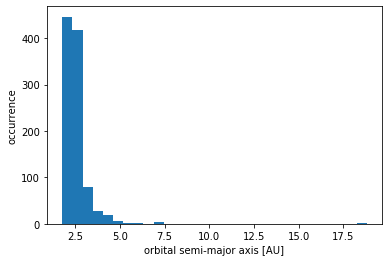

In [15]:
sma = [x[s.system.param_idx['sma1']] for x in orbits]

%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(sma, bins=30)
plt.xlabel('orbital semi-major axis [AU]')
plt.ylabel('occurrence')
# plt.xlim([0,20])
plt.show()

You can use this method to create histograms of any orbital element you are interested in:

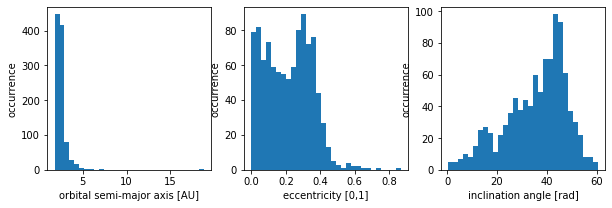

In [16]:
ecc = [x[s.system.param_idx['ecc1']] for x in orbits]
i = [x[s.system.param_idx['inc1']] for x in orbits]

plt.figure(figsize=(10,3))
plt.subplot(131)
plt.hist(sma, bins=30)
plt.xlabel('orbital semi-major axis [AU]')
plt.ylabel('occurrence')

plt.subplot(132)
plt.hist(ecc, bins=30)
plt.xlabel('eccentricity [0,1]')
plt.ylabel('occurrence')

plt.subplot(133)
plt.hist(np.degrees(i), bins=30)
plt.xlabel('inclination angle [rad]')
plt.ylabel('occurrence')

plt.show()

In addition to our `orbits` array, Orbitize also creates a `Results` class that contains built-in plotting capabilities for two types of plots: corner plots and orbit plots.  

### Corner Plot ###

After generating the samples, the `run_sampler` method also creates a `Results` object that can be accessed
with `s.results`:

In [17]:
myResults = s.results

We can now create a corner plot using the function `plot_corner` within the `Results` class. This function requires an input list of the parameters, in string format, that you wish to include in your corner plot. We can even plot all of the orbital parameters at once! As shown below:

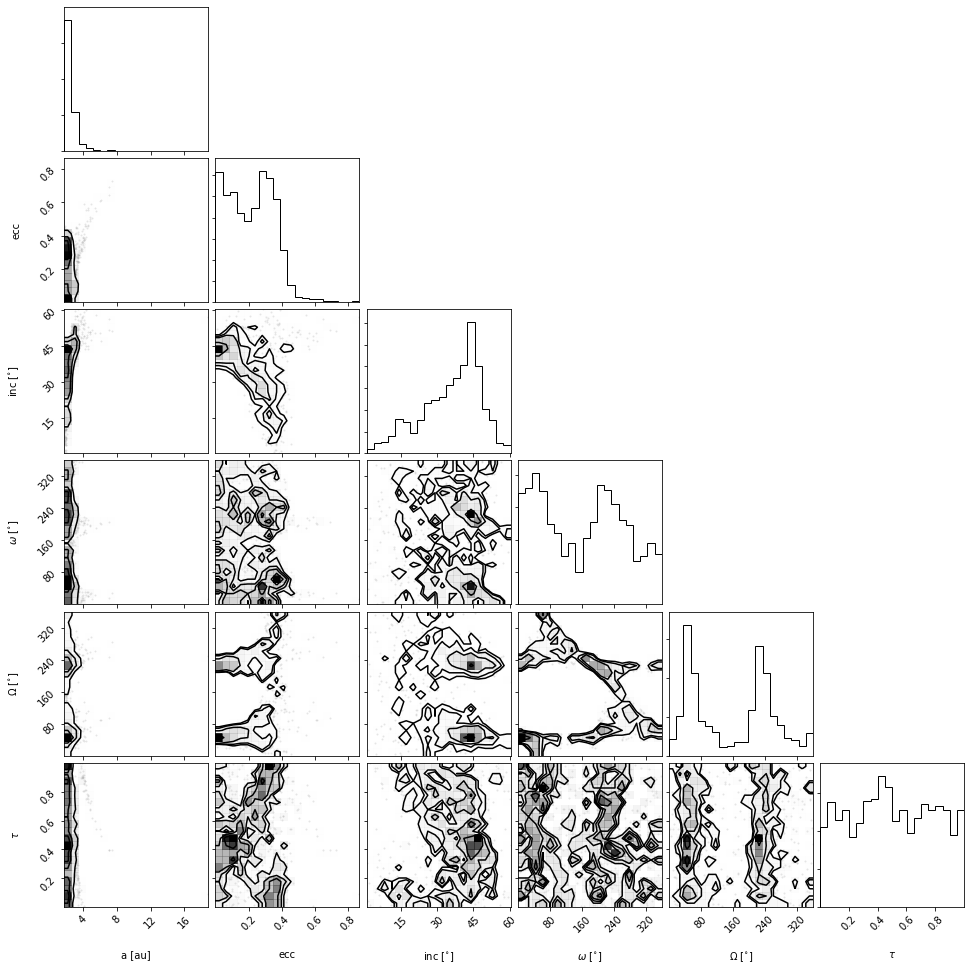

In [18]:
corner_figure = myResults.plot_corner(param_list=['sma1', 'ecc1', 'inc1', 'aop1', 'pan1','tau1'])

### A Note about Convergence

Those of you with experience looking at corner plots will note that the result here does not look converged (i.e. we need more samples for our results to be statistically significant). Because this is a tutorial, we didn't want you to have to wait around for a while for the OFTI results to converge.

**It's safe to say that OFTI should accept a minimum of 10,000 orbit for convergence. For pretty plots to go in publications, we recommend at least 1,000,000 accepted orbits.**

### Orbit Plot ###

What about if we want to see how the orbits look in the sky? Don't worry, the `Results` class has a command for that too! It's called `plot_orbits`. We can create a simple orbit plot by running the command as follows:

<Figure size 1008x432 with 0 Axes>

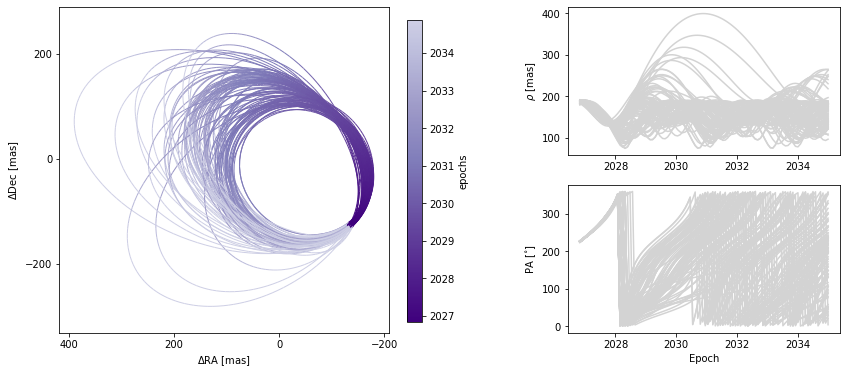

In [19]:
epochs = myDriver.system.data_table['epoch']
orbit_figure = myResults.plot_orbits(
    start_mjd = epochs[0], sep_pa_end_year = 2035) # Minimum MJD for colorbar (here we choose first data epoch)
# )

## Advanced OFTI and API Interaction ##

We've seen how the `run_sampler` command is the fastest way to generate orbits within OFTI. For users interested in what's going on under-the-hood, this part of the tutorial takes us each step of `run_sampler`. Understanding the intermediate stages of orbit-fitting can allow for more customization that goes beyond Orbitize's default parameters.

We begin again by intializing a `sampler` object on which we can run OFTI:

In [20]:
myDriver = orbitize.driver.Driver(astrometry_table_path, # path to data file
                                  'OFTI', # name of algorithm for orbit-fitting
                                  1, # number of secondary bodies in system
                                  1, # total system mass [M_sun]
                                  plx, # total parallax of system [mas]
                                  mass_err=0.05, # mass error [M_sun]
                                  plx_err=plx_err) # parallax error [mas]

Converting ra/dec data points in data_table to sep/pa. Original data are stored in input_table.


In [21]:
s = myDriver.sampler

In orbitize, the first thing that OFTI does is prepare an initial set of possible orbits for our object through a function called `prepare_samples`, which takes in the number of orbits to generate as an input. For example, we can generate 10,000 orbits as follows:

In [22]:
samples = s.prepare_samples(10000)

Here, `samples` is an array of randomly generated orbits that have been scaled-and-rotated to fit our astrometric observations. The first and second dimension of this array are the number of orbital elements and total orbits generated, respectively. In other words, each element in `samples` represents the value of a particular orbital element for each generated orbit:

In [23]:
print('samples: ', samples.shape)
print('first element of samples: ', samples[0].shape)

samples:  (8, 10000)
first element of samples:  (10000,)


Once our initial set of orbits is generated, the orbits are vetted for likelihood in a function called `reject`. This function computes the probability of an orbit based on its associated chi squared. It then rejects orbits with lower likelihoods and accepts the orbits that are more probable. The output of this function is an array of possible orbits for our input system.

In [24]:
orbits, lnlikes = s.reject(samples)

Our `orbits` array represents the final orbits that are output by OFTI. Each element in this array contains the 8 orbital elements that are computed by orbitize:

In [25]:
orbits.shape

(0,)

We can synthesize this sequence with the `run_sampler()` command, which runs through the steps above until the input number of orbits has been accepted. Additionally, we can specify the number of orbits generated by `prepare_samples` each time the sequence is initiated with an argument called `num_samples`. Higher values for `num_samples` will output more accepted orbits, but may take longer to run since all initially prepared orbits will be run through the rejection step.

In [26]:
orbits = s.run_sampler(100, num_samples=1000)

## Saving and Loading Results ##

Finally, we can save our generated orbits in a file that can be easily read for future use and analysis. Here we will walk through the steps of saving a set of orbits to a file in hdf5 format. Note that this functionality can be performed automatically using ``orbitize.Results.save_results()``.

In [27]:
import h5py
f = h5py.File('orbits_planet_' + planet + '.hdf5', 'w')

Next we want to store the data (in our case, the `orbits` array generated by OFTI above) in a dataset within the file we've created:

In [28]:
f.create_dataset('orbits', data=orbits)
f.close()

Once you are done writing data to your file, closing the file will end any processes involved in opening and writing the file. Now when you are ready to use your orbits data, it is easily accessible through the file we've created:

In [29]:
f = h5py.File('orbits_planet_'+planet+'.hdf5', 'r')
orbits = f['orbits']

print('orbits array dimensions: ', orbits.shape)
print('orbital elements for first orbit: ', orbits[0])

f.close()

orbits array dimensions:  (100, 8)
orbital elements for first orbit:  [ 3.08252667  0.15976772  0.85094099  3.28142047  0.83794987  0.26452018
 72.49045251  0.97472065]


The way you can perform it automatically with ``orbitize.Results.save_results()`` is shown below:

In [30]:
myResults = s.results
myResults.save_results('./planet_'+ planet +'_results.hdf5')

And now we can easily work with the saved orbits that were generated by Orbitize! Find out more about generating orbits in Orbitize with tutorials [here](https://orbitize.readthedocs.io/en/latest/tutorials.html).